# Miniproject 1: Image Classification

## Introduction

### Important dates:

- Project release: Friday, 15th March 2019
- **Submission deadline**: Monday, 29th April 2019, 11:59 pm

### Description

One of the deepest traditions in learning about deep learning is to first [tackle the exciting problem of MNIST classification](http://yann.lecun.com/exdb/mnist/). [The MNIST database](https://en.wikipedia.org/wiki/MNIST_database) (Modified National Institute of Standards and Technology database) is a large database of handwritten digits that is commonly used as a first test for new classification algorithms. 
We follow this tradition to investigate the performance of artificial neural networks of different complexity on MNIST. However, since MNIST is too easy for accessing the full power of modern machine learning algorithms (see e.g. [this post](https://twitter.com/goodfellow_ian/status/852591106655043584)) we will extend our analysis to the recently introduced, harder [Fashion-MNIST dataset](https://github.com/zalandoresearch/fashion-mnist).


### Prerequisites

- You should have a running installation of [tensorflow](https://www.tensorflow.org/install/) and [keras](https://keras.io/). Feel free to gain inspiration from the [Keras example directory](https://github.com/keras-team/keras/tree/master/examples) for your implementations.
- You should know the concepts "multilayer perceptron", "stochastic gradient descent with minibatches", "convolutional neural network", "training and validation data", "overfitting" and "early stopping".

### What you will learn

- You will learn how to define feedforward neural networks in keras and fit them to data.
- You will be guided through a prototyping procedure for the application of deep learning to a specific domain.
- You will get in contact with concepts discussed later in the lecture, like "regularization", "batch normalization" and "convolutional networks".
- You will gain some experience on the influence of network architecture, optimizer and regularization choices on the goodness of fit.
- You will learn to be more patient :) Some fits may take your computer quite a bit of time; run them over night (or on an external server).

### Evaluation criteria

The evaluation is (mostly) based on the figures you submit and your answer sentences. Provide clear and concise answers respecting the indicated maximum length (answers to the questions should be below the line that says "Answer to question ...").

**The submitted notebook must be run by you!** We will only do random tests of your code and not re-run the full notebook. There will be fraud detection sessions at the end of the semester.

### Your names

**Before you start**: please enter your full name(s) in the field below.

In [1]:
student1 = "Luca Viano"
student2 = "Joachim Jacques Koerfer"

## Some helper functions

For your convenience we provide here some functions to preprocess the data and plot the results later. Simply run the following cells with `Shift-Enter`.

### Dependencies and constants

In [2]:
%matplotlib inline

import numpy as np
import time
import matplotlib.pyplot as plt
import scipy.io

import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten, Activation
from keras.optimizers import SGD, Adam

Using TensorFlow backend.


### Plotting

In [3]:
def plot_some_samples(x, y = [], yhat = [], select_from = [], 
                      ncols = 6, nrows = 4, xdim = 28, ydim = 28,
                      label_mapping = range(10)):
    """plot some input vectors as grayscale images (optionally together with their assigned or predicted labels).
    
    x is an NxD - dimensional array, where D is the length of an input vector and N is the number of samples.
    Out of the N samples, ncols x nrows indices are randomly selected from the list select_from (if it is empty, select_from becomes range(N)).
    
    Keyword arguments:
    y             -- corresponding labels to plot in green below each image.
    yhat          -- corresponding predicted labels to plot in red below each image.
    select_from   -- list of indices from which to select the images.
    ncols, nrows  -- number of columns and rows to plot.
    xdim, ydim    -- number of pixels of the images in x- and y-direction.
    label_mapping -- map labels to digits.
    
    """
    fig, ax = plt.subplots(nrows, ncols)
    if len(select_from) == 0:
        select_from = range(x.shape[0])
    indices = np.random.choice(select_from, size = min(ncols * nrows, len(select_from)), replace = False)
    for i, ind in enumerate(indices):
        thisax = ax[i//ncols,i%ncols]
        thisax.matshow(x[ind].reshape(xdim, ydim), cmap='gray')
        thisax.set_axis_off()
        if len(y) != 0:
            j = y[ind] if type(y[ind]) != np.ndarray else y[ind].argmax()
            thisax.text(0, 0, (label_mapping[j])%10, color='green', 
                                                       verticalalignment='top',
                                                       transform=thisax.transAxes)
        if len(yhat) != 0:
            k = yhat[ind] if type(yhat[ind]) != np.ndarray else yhat[ind].argmax()
            thisax.text(1, 0, (label_mapping[k])%10, color='red',
                                             verticalalignment='top',
                                             horizontalalignment='right',
                                             transform=thisax.transAxes)
    return fig

def prepare_standardplot(title, xlabel):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.suptitle(title)
    ax1.set_ylabel('categorical cross entropy')
    ax1.set_xlabel(xlabel)
    ax1.set_yscale('log')
    ax2.set_ylabel('accuracy [% correct]')
    ax2.set_xlabel(xlabel)
    return fig, ax1, ax2

def finalize_standardplot(fig, ax1, ax2):
    ax1handles, ax1labels = ax1.get_legend_handles_labels()
    if len(ax1labels) > 0:
        ax1.legend(ax1handles, ax1labels)
    ax2handles, ax2labels = ax2.get_legend_handles_labels()
    if len(ax2labels) > 0:
        ax2.legend(ax2handles, ax2labels)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9)

def plot_history(history, title):
    fig, ax1, ax2 = prepare_standardplot(title, 'epoch')
    ax1.plot(history.history['loss'], label = "training")
    ax1.plot(history.history['val_loss'], label = "validation")
    ax2.plot(history.history['acc'], label = "training")
    ax2.plot(history.history['val_acc'], label = "validation")
    finalize_standardplot(fig, ax1, ax2)
    return fig


## Exercise 1: Data import and visualization (4 points)

### Description

### Loading the data

The datasets we use in this project (MNIST, Fashion-MNIST) consists of grayscale images with 28x28 pixels. Keras comes with a convenient in-built [data importer](https://keras.io/datasets/) for common datasets.

1. As a warm-up exercise, use this importer to (down-)load the MNIST and Fashion-MNIST dataset. Assign useful variables to test & train images and labels for both datasets respectively. (2 pts)
2. Use the corresponding plotting function defined above to plot some samples of the two datasets. What do the green digits at the bottom left of each image indicate? (1 sentence max.) (2 pts)

The low resolution (and grayscale) of the images certainly misses some information that could be helpful for classifying the images. However, since the data has lower dimensionality due to the low resolution, the fitting procedures converge faster. This is an advantage in situations like here (or generally when prototyping), were we want to try many different things without having to wait too long for computations to finish.



### Solution

In [4]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
(x_fashion_train, y_fashion_train), (x_fashion_test, y_fashion_test) = fashion_mnist.load_data()

Answer to question 2: 
* the green digits correspond to the labels of the data set, i.e. different digits for each category.

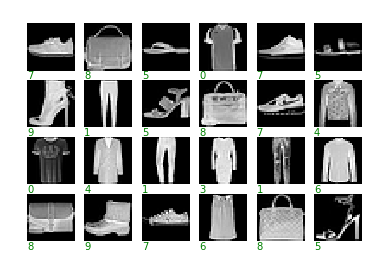

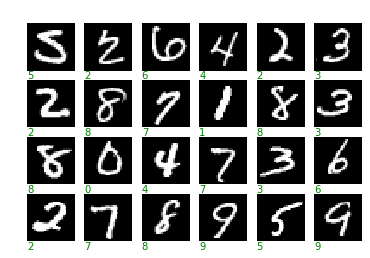

In [5]:
plot_some_samples(x_fashion_train, y_fashion_train)
plot_some_samples(x_train, y_train)
print() #Avoid duplication of output from Jupyter

**Data pre-processing**: To prepare for fitting we transform the labels to one hot coding, i.e. for 5 classes, label 2 becomes the vector [0, 0, 1, 0, 0] (python uses 0-indexing). Furthermore we reshape (flatten) the input images to input vectors and rescale the data into the range [0,1].

In [6]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

y_fashion_train = keras.utils.to_categorical(y_fashion_train)
y_fashion_test = keras.utils.to_categorical(y_fashion_test)

In [7]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1]*x_train.shape[2])/np.max(x_train)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1]*x_test.shape[2])/np.max(x_test)

x_fashion_train = x_fashion_train.reshape(x_fashion_train.shape[0], x_fashion_train.shape[1]*x_fashion_train.shape[2])/np.max(x_fashion_train)
x_fashion_test = x_fashion_test.reshape(x_fashion_test.shape[0], x_fashion_test.shape[1]*x_fashion_test.shape[2])/np.max(x_fashion_test)

In [8]:
noutputs = 10
ninputs = x_train.shape[1]
batch_size = 128

## Exercise 2: No hidden layer (10 points)

### Description

Define and fit a model without a hidden layer (since we will use multi-layer models later in this project, you can define a general constructor function for models with an arbitrary number of hidden layers already at this point). (1 pt for each step)

1. Use the softmax activation for the output layer.
2. Use the categorical_crossentropy loss.
3. Add the accuracy metric to the metrics.
4. Choose stochastic gradient descent for the optimizer.
5. Choose a minibatch size of 128.
6. Fit for as many epochs as needed to see no further decrease in the validation loss.
7. Plot the output of the fitting procedure (a history object) using the function plot_history defined above.
8. Determine the indices of all test images that are misclassified by the fitted model and plot some of them using the function 
   `plot_some_samples(x_test, y_test, yhat_test, error_indices)`. Explain the green and red digits at the bottom of each image.
9. Repeat the above steps for fitting the network to the Fashion-MNIST dataset.


Hints:
* Read the keras docs, in particular [Getting started with the Keras Sequential model](https://keras.io/getting-started/sequential-model-guide/).
* Have a look at the keras [examples](https://github.com/keras-team/keras/tree/master/examples), e.g. [mnist_mlp](https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py).

### Solution

Answer to question 8:
* The red digit is the prediction of the model and the green is the correct label associated to the image

#### MNIST DATA SET

In [16]:
noutputs = 10
ninputs = x_train.shape[1]
batch_size = 128
epochs = 150


model_no_hidden_layer = Sequential([
    Dense(noutputs, input_shape=(ninputs,)),
    Activation('softmax'),
])

model_no_hidden_layer.compile(loss='categorical_crossentropy',
      optimizer=SGD(), 
      metrics=['accuracy'])

MNIST_history = model_no_hidden_layer.fit(x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data = (x_test, y_test),
    shuffle=True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/150
60000/60000 [==============================] - 1s 22us/step - loss: 1.3026 - acc: 0.6861 - val_loss: 0.8095 - val_acc: 0.8346
Epoch 2/150
60000/60000 [==============================] - 1s 18us/step - loss: 0.7158 - acc: 0.8422 - val_loss: 0.6031 - val_acc: 0.8643
Epoch 3/150
60000/60000 [==============================] - 1s 18us/step - loss: 0.5852 - acc: 0.8605 - val_loss: 0.5213 - val_acc: 0.8772
Epoch 4/150
60000/60000 [==============================] - 1s 18us/step - loss: 0.5233 - acc: 0.8700 - val_loss: 0.4759 - val_acc: 0.8822
Epoch 5/150
60000/60000 [==============================] - 1s 18us/step - loss: 0.4859 - acc: 0.8763 - val_loss: 0.4466 - val_acc: 0.8869
Epoch 6/150
60000/60000 [==============================] - 1s 17us/step - loss: 0.4602 - acc: 0.8816 - val_loss: 0.4257 - val_acc: 0.8892
Epoch 7/150
60000/60000 [==============================] - 1s 17us/step - loss: 0.4412 - acc: 0.8847 - val_loss: 0.4096 - 

Epoch 118/150
60000/60000 [==============================] - 1s 15us/step - loss: 0.2823 - acc: 0.9211 - val_loss: 0.2790 - val_acc: 0.9222
Epoch 119/150
60000/60000 [==============================] - 1s 15us/step - loss: 0.2821 - acc: 0.9214 - val_loss: 0.2789 - val_acc: 0.9222
Epoch 120/150
60000/60000 [==============================] - 1s 15us/step - loss: 0.2819 - acc: 0.9212 - val_loss: 0.2786 - val_acc: 0.9223
Epoch 121/150
60000/60000 [==============================] - 1s 16us/step - loss: 0.2816 - acc: 0.9214 - val_loss: 0.2787 - val_acc: 0.9215
Epoch 122/150
60000/60000 [==============================] - 1s 15us/step - loss: 0.2814 - acc: 0.9215 - val_loss: 0.2785 - val_acc: 0.9220
Epoch 123/150
60000/60000 [==============================] - 1s 15us/step - loss: 0.2813 - acc: 0.9215 - val_loss: 0.2784 - val_acc: 0.9221
Epoch 124/150
60000/60000 [==============================] - 1s 15us/step - loss: 0.2810 - acc: 0.9216 - val_loss: 0.2781 - val_acc: 0.9227
Epoch 125/150
60000/

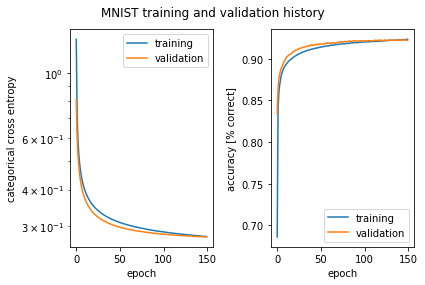

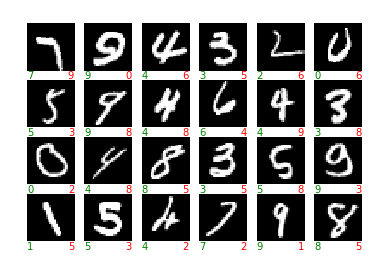

In [17]:
plot_history(MNIST_history, "MNIST training and validation history")

"""
We want to shape the prediction in one-hot encoding to compare it with the labels.
We put the maxixum in a row to 1 and the rest to 0
"""
yhat_test = model_no_hidden_layer.predict(x_test, batch_size=batch_size)

yhat_test_max = np.repeat(np.max(yhat_test, axis=1).reshape((yhat_test.shape[0], 1)), 10, axis=1)
yhat_test = np.where(yhat_test == yhat_test_max, 1, 0)

error_indices = np.argwhere(yhat_test != y_test) #Find rows and columns that are different
#Unique() to avoid rows indices duplicates (because y_fashion_test is one-hot encoding, and argwhere will find two different in one row if the prediction is wrong)
error_indices = np.unique(error_indices[:,0])
plot_some_samples(x_test, y_test, yhat_test, error_indices)
print()

#### MNIST_FASHION DATA SET

In [14]:
epochs = 300
MNIST_FASHION_history = model_no_hidden_layer.fit(x_fashion_train, y_fashion_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data = (x_fashion_test, y_fashion_test),
    shuffle=True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/300
60000/60000 [==============================] - 1s 20us/step - loss: 2.4342 - acc: 0.3563 - val_loss: 1.3416 - val_acc: 0.5632
Epoch 2/300
60000/60000 [==============================] - 1s 18us/step - loss: 1.1400 - acc: 0.6216 - val_loss: 1.0176 - val_acc: 0.6559
Epoch 3/300
60000/60000 [==============================] - 1s 17us/step - loss: 0.9355 - acc: 0.6840 - val_loss: 0.8906 - val_acc: 0.6952
Epoch 4/300
60000/60000 [==============================] - 1s 20us/step - loss: 0.8354 - acc: 0.7147 - val_loss: 0.8151 - val_acc: 0.7214
Epoch 5/300
60000/60000 [==============================] - 1s 16us/step - loss: 0.7713 - acc: 0.7356 - val_loss: 0.7626 - val_acc: 0.7385
Epoch 6/300
60000/60000 [==============================] - 1s 15us/step - loss: 0.7252 - acc: 0.7507 - val_loss: 0.7252 - val_acc: 0.7514
Epoch 7/300
60000/60000 [==============================] - 1s 17us/step - loss: 0.6902 - acc: 0.7622 - val_loss: 0.6948 - 

Epoch 118/300
60000/60000 [==============================] - 1s 17us/step - loss: 0.4137 - acc: 0.8583 - val_loss: 0.4562 - val_acc: 0.8397
Epoch 119/300
60000/60000 [==============================] - 1s 16us/step - loss: 0.4133 - acc: 0.8588 - val_loss: 0.4562 - val_acc: 0.8412
Epoch 120/300
60000/60000 [==============================] - 1s 16us/step - loss: 0.4131 - acc: 0.8590 - val_loss: 0.4563 - val_acc: 0.8409
Epoch 121/300
60000/60000 [==============================] - 1s 15us/step - loss: 0.4129 - acc: 0.8588 - val_loss: 0.4555 - val_acc: 0.8404
Epoch 122/300
60000/60000 [==============================] - 1s 15us/step - loss: 0.4125 - acc: 0.8590 - val_loss: 0.4560 - val_acc: 0.8396
Epoch 123/300
60000/60000 [==============================] - 1s 16us/step - loss: 0.4121 - acc: 0.8590 - val_loss: 0.4556 - val_acc: 0.8398
Epoch 124/300
60000/60000 [==============================] - 1s 16us/step - loss: 0.4119 - acc: 0.8590 - val_loss: 0.4553 - val_acc: 0.8399
Epoch 125/300
60000/

60000/60000 [==============================] - 1s 14us/step - loss: 0.3926 - acc: 0.8651 - val_loss: 0.4419 - val_acc: 0.8447
Epoch 235/300
60000/60000 [==============================] - 1s 15us/step - loss: 0.3925 - acc: 0.8655 - val_loss: 0.4416 - val_acc: 0.8444
Epoch 236/300
60000/60000 [==============================] - 1s 15us/step - loss: 0.3926 - acc: 0.8653 - val_loss: 0.4420 - val_acc: 0.8438
Epoch 237/300
60000/60000 [==============================] - 1s 15us/step - loss: 0.3923 - acc: 0.8654 - val_loss: 0.4427 - val_acc: 0.8438
Epoch 238/300
60000/60000 [==============================] - 1s 15us/step - loss: 0.3922 - acc: 0.8649 - val_loss: 0.4416 - val_acc: 0.8436
Epoch 239/300
60000/60000 [==============================] - 1s 14us/step - loss: 0.3920 - acc: 0.8651 - val_loss: 0.4439 - val_acc: 0.8430
Epoch 240/300
60000/60000 [==============================] - 1s 17us/step - loss: 0.3920 - acc: 0.8655 - val_loss: 0.4414 - val_acc: 0.8442
Epoch 241/300
60000/60000 [=======

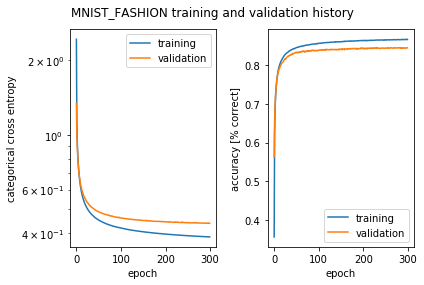

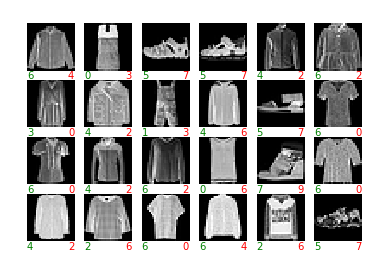

In [15]:
plot_history(MNIST_FASHION_history, "MNIST_FASHION training and validation history")

"""
We want to shape the prediction in one-hot encoding to compare it with the labels.
We put the maxixum in a row to 1 and the rest to 0
"""
yhat_fashion_test = model_no_hidden_layer.predict(x_fashion_test, batch_size=batch_size)

yhat_fashion_test_max = np.repeat(np.max(yhat_fashion_test, axis=1).reshape((yhat_fashion_test.shape[0], 1)), 10, axis=1)
yhat_fashion_test = np.where(yhat_fashion_test == yhat_fashion_test_max, 1, 0)

error_fashion_indices = np.argwhere(yhat_fashion_test != y_fashion_test) #Find rows and columns that are different
#Unique() to avoid rows indices duplicates (because y_fashion_test is one-hot encoding, and argwhere will find two different in one row if the prediction is wrong)
error_fashion_indices = np.unique(error_fashion_indices[:,0])
plot_some_samples(x_fashion_test, y_fashion_test, yhat_fashion_test, error_fashion_indices)
print()

## Exercise 3: One hidden layer, different optizimizers & overfitting (10 points)

### Description

Train a network with one hidden layer and compare different optimizers.

1. Use one hidden layer with 128 units and the 'relu' activation. Use the [summary method](https://keras.io/models/about-keras-models/) to display your model in a compact way. (1 pt)
2. Fit the model for 50 epochs with different learning rates of stochastic gradient descent (SGD). (1pt)
3. Replace the stochastic gradient descent optimizer with the [Adam optimizer](https://keras.io/optimizers/#adam). (1pt)
4. Plot the learning curves of SGD with a reasonable learning rate (i.e. in the range [0.01,0.1]) together with the learning curves of Adam in the same figure. Take care of a reasonable labeling of the curves in the plot. (2pts)
5. Answer the questions below. (4pts)
6. Run the network (using the Adam optimizer) on the Fashion-MNIST dataset and plot the learning curves using the plot_history function defined above. (1pt)

### Solution

#### Question 3.1

In [18]:
"""
Define the model for Question 3
"""
noutputs = 10
ninputs = x_train.shape[1]
epochs = 50
batch_size = 128

model_1hidden_layer = Sequential([
    Dense(128, input_shape=(ninputs,)), Activation('relu'),
    Dense(noutputs),
    Activation('softmax'),
])
model_1hidden_layer.summary() #Print summary

weights_1hidden_layer = model_1hidden_layer.get_weights()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 128)               100480    
_________________________________________________________________
activation_3 (Activation)    (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                1290      
_________________________________________________________________
activation_4 (Activation)    (None, 10)                0         
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


#### Question 3.2

In [19]:
#Very small learning rate, very large lr, and reasonable lr
lrs = [1e-5, 2, 0.01, 0.05, 0.1]
MNIST_SGD_histories = []
for lr in lrs: 
    print("Learning rate : ", lr)
    model_1hidden_layer.compile(loss='categorical_crossentropy',
          optimizer=SGD(lr=lr), 
          metrics=['accuracy'])

    model_1hidden_layer.set_weights(weights_1hidden_layer)
    
    MNIST_SGD_histories.append(model_1hidden_layer.fit(x_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data = (x_test, y_test),
        shuffle=True))

Learning rate :  1e-05
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 1s 21us/step - loss: 2.4535 - acc: 0.0872 - val_loss: 2.4502 - val_acc: 0.0882
Epoch 2/50
60000/60000 [==============================] - 1s 17us/step - loss: 2.4457 - acc: 0.0876 - val_loss: 2.4424 - val_acc: 0.0884
Epoch 3/50
60000/60000 [==============================] - 1s 18us/step - loss: 2.4382 - acc: 0.0880 - val_loss: 2.4348 - val_acc: 0.0890
Epoch 4/50
60000/60000 [==============================] - 1s 18us/step - loss: 2.4308 - acc: 0.0883 - val_loss: 2.4273 - val_acc: 0.0902
Epoch 5/50
60000/60000 [==============================] - 1s 19us/step - loss: 2.4235 - acc: 0.0886 - val_loss: 2.4200 - val_acc: 0.0916
Epoch 6/50
60000/60000 [==============================] - 1s 19us/step - loss: 2.4165 - acc: 0.0891 - val_loss: 2.4129 - val_acc: 0.0907
Epoch 7/50
60000/60000 [==============================] - 1s 19us/step - loss: 2.4096 - acc: 0.0898 - val

Epoch 18/50
60000/60000 [==============================] - 1s 17us/step - loss: 0.2349 - acc: 0.9339 - val_loss: 0.2292 - val_acc: 0.9350
Epoch 19/50
60000/60000 [==============================] - 1s 18us/step - loss: 0.2302 - acc: 0.9351 - val_loss: 0.2243 - val_acc: 0.9369
Epoch 20/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.2256 - acc: 0.9364 - val_loss: 0.2210 - val_acc: 0.9367
Epoch 21/50
60000/60000 [==============================] - 1s 18us/step - loss: 0.2212 - acc: 0.9381 - val_loss: 0.2171 - val_acc: 0.9387
Epoch 22/50
60000/60000 [==============================] - 1s 23us/step - loss: 0.2169 - acc: 0.9389 - val_loss: 0.2128 - val_acc: 0.9391
Epoch 23/50
60000/60000 [==============================] - 1s 20us/step - loss: 0.2128 - acc: 0.9407 - val_loss: 0.2091 - val_acc: 0.9396
Epoch 24/50
60000/60000 [==============================] - 1s 17us/step - loss: 0.2089 - acc: 0.9415 - val_loss: 0.2053 - val_acc: 0.9408
Epoch 25/50
60000/60000 [=========

Epoch 27/50
60000/60000 [==============================] - 1s 18us/step - loss: 0.0696 - acc: 0.9809 - val_loss: 0.0897 - val_acc: 0.9732
Epoch 28/50
60000/60000 [==============================] - 1s 18us/step - loss: 0.0675 - acc: 0.9818 - val_loss: 0.0898 - val_acc: 0.9726
Epoch 29/50
60000/60000 [==============================] - 2s 32us/step - loss: 0.0657 - acc: 0.9820 - val_loss: 0.0863 - val_acc: 0.9742
Epoch 30/50
60000/60000 [==============================] - 1s 22us/step - loss: 0.0637 - acc: 0.9830 - val_loss: 0.0860 - val_acc: 0.9740
Epoch 31/50
60000/60000 [==============================] - 1s 22us/step - loss: 0.0616 - acc: 0.9831 - val_loss: 0.0849 - val_acc: 0.9742
Epoch 32/50
60000/60000 [==============================] - 1s 19us/step - loss: 0.0600 - acc: 0.9836 - val_loss: 0.0838 - val_acc: 0.9747
Epoch 33/50
60000/60000 [==============================] - 1s 17us/step - loss: 0.0581 - acc: 0.9842 - val_loss: 0.0825 - val_acc: 0.9752
Epoch 34/50
60000/60000 [=========

Epoch 36/50
60000/60000 [==============================] - 1s 17us/step - loss: 0.0255 - acc: 0.9948 - val_loss: 0.0689 - val_acc: 0.9793
Epoch 37/50
60000/60000 [==============================] - 1s 17us/step - loss: 0.0247 - acc: 0.9949 - val_loss: 0.0687 - val_acc: 0.9798
Epoch 38/50
60000/60000 [==============================] - 1s 17us/step - loss: 0.0238 - acc: 0.9952 - val_loss: 0.0678 - val_acc: 0.9792
Epoch 39/50
60000/60000 [==============================] - 1s 17us/step - loss: 0.0228 - acc: 0.9956 - val_loss: 0.0676 - val_acc: 0.9794
Epoch 40/50
60000/60000 [==============================] - 1s 17us/step - loss: 0.0219 - acc: 0.9960 - val_loss: 0.0675 - val_acc: 0.9803
Epoch 41/50
60000/60000 [==============================] - 1s 17us/step - loss: 0.0212 - acc: 0.9960 - val_loss: 0.0688 - val_acc: 0.9795
Epoch 42/50
60000/60000 [==============================] - 1s 17us/step - loss: 0.0204 - acc: 0.9960 - val_loss: 0.0676 - val_acc: 0.9796
Epoch 43/50
60000/60000 [=========

#### Question 3.3

In [88]:
model_1hidden_layer.compile(loss='categorical_crossentropy',
      optimizer=Adam(), 
      metrics=['accuracy'])

model_1hidden_layer.set_weights(weights_1hidden_layer)

MNIST_adam_history = model_1hidden_layer.fit(x_train, y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data = (x_test, y_test),
    shuffle=True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 43us/step - loss: 0.3528 - acc: 0.9042 - val_loss: 0.1919 - val_acc: 0.9444
Epoch 2/50
60000/60000 [==============================] - 2s 27us/step - loss: 0.1660 - acc: 0.9530 - val_loss: 0.1397 - val_acc: 0.9619
Epoch 3/50
60000/60000 [==============================] - 1s 25us/step - loss: 0.1221 - acc: 0.9655 - val_loss: 0.1187 - val_acc: 0.9663
Epoch 4/50
60000/60000 [==============================] - 1s 24us/step - loss: 0.0951 - acc: 0.9724 - val_loss: 0.1037 - val_acc: 0.9678
Epoch 5/50
60000/60000 [==============================] - 1s 24us/step - loss: 0.0788 - acc: 0.9779 - val_loss: 0.0895 - val_acc: 0.9748
Epoch 6/50
60000/60000 [==============================] - 1s 24us/step - loss: 0.0645 - acc: 0.9814 - val_loss: 0.0868 - val_acc: 0.9759
Epoch 7/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.0556 - acc: 0.9842 - val_loss: 0.0847 - val_acc

#### Question 3.4

In [28]:
# This plotting routine might help you ...
def comparison_plot(history_sgd, history_adam, label1, label2, title):
    fig, ax1, ax2 = prepare_standardplot(title, "epochs")
    ax1.plot(history_sgd.history['loss'], label=label1 + ' training')
    ax1.plot(history_sgd.history['val_loss'], label=label1 + ' validation')
    ax1.plot(history_adam.history['loss'], label=label2 + ' training')
    ax1.plot(history_adam.history['val_loss'], label=label2 + ' validation')
    ax2.plot(history_sgd.history['acc'], label=label1 + ' training')
    ax2.plot(history_sgd.history['val_acc'], label=label1 + ' validation')
    ax2.plot(history_adam.history['acc'], label=label2 + ' training')
    ax2.plot(history_adam.history['val_acc'], label=label2 + ' validation')
    finalize_standardplot(fig, ax1, ax2)
    return fig

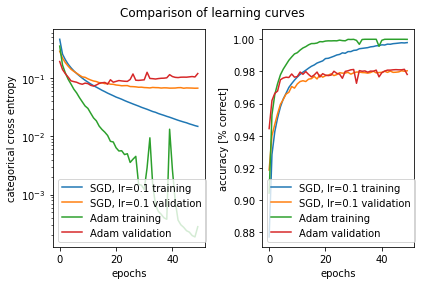

In [91]:
comparison_plot(MNIST_SGD_histories[4], MNIST_adam_history, "SGD, lr=0.1", "Adam", "Comparison of learning curves")
print()

**Question**: What happens if the learning rate of SGD is A) very large B) very small? Please answer A) and B) with one full sentence each (double click this markdown cell to edit).

**Answer**:

A) If the learning rate is very large, then SGD becomes unstable and its accuracy oscillates

B) If it is very small, SGD learns very slowly and thus it almost does not improve the accuracy

**Question**: At which epoch (approximately) does the Adam optimizer start to overfit (on MNIST)? Please answer with one full sentence.

**Answer**: About epoch 15, Adam starts to overfit on MNIST.

**Question**: Explain the qualitative difference between the loss curves and the accuracy curves with respect to signs of overfitting. Please answer with at most 3 full sentences.

**Answer**: In the validation loss curve, overfitting starts when the curve has reached a minimum and starts increasing while the training loss is still decreasing. In the accuracy plot, both the curves (validation and training) start to reach a plateau and to oscillate around the plateau value when they begin to overfit.

#### Question 3.6

In [92]:
model_1hidden_layer.compile(loss='categorical_crossentropy',
      optimizer=Adam(), 
      metrics=['accuracy'])

MNIST_fashion_adam_history = model_1hidden_layer.fit(x_fashion_train, y_fashion_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data = (x_fashion_test, y_fashion_test),
    shuffle=True)

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 43us/step - loss: 2.6758 - acc: 0.6799 - val_loss: 0.6904 - val_acc: 0.7900
Epoch 2/50
60000/60000 [==============================] - 1s 24us/step - loss: 0.5455 - acc: 0.8219 - val_loss: 0.5233 - val_acc: 0.8321
Epoch 3/50
60000/60000 [==============================] - 1s 24us/step - loss: 0.4425 - acc: 0.8493 - val_loss: 0.4599 - val_acc: 0.8479
Epoch 4/50
60000/60000 [==============================] - 2s 26us/step - loss: 0.3924 - acc: 0.8633 - val_loss: 0.4370 - val_acc: 0.8532
Epoch 5/50
60000/60000 [==============================] - 1s 24us/step - loss: 0.3652 - acc: 0.8706 - val_loss: 0.4219 - val_acc: 0.8590
Epoch 6/50
60000/60000 [==============================] - 1s 24us/step - loss: 0.3442 - acc: 0.8780 - val_loss: 0.4105 - val_acc: 0.8602
Epoch 7/50
60000/60000 [==============================] - 1s 24us/step - loss: 0.3279 - acc: 0.8827 - val_loss: 0.3987 - val_acc

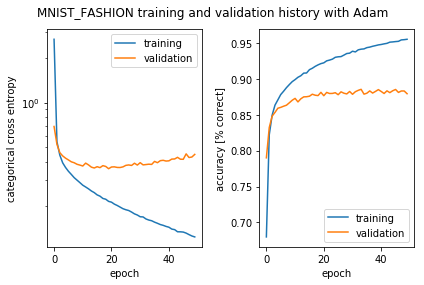

In [93]:
plot_history(MNIST_fashion_adam_history, "MNIST_FASHION training and validation history with Adam")
print()

## Exercise 4: Model performance as a function of number of hidden neurons (8 points)

### Description

Investigate how the best validation loss and accuracy depends on the number of hidden neurons in a single layer.

1. Fit a reasonable number of models (e.g. 5) with different hidden layer sizes (between 10 and 1000 hidden neurons) to the MNIST dataset. You may use the Adam optimizer and a meaningful number of epochs (overfitting!). (3 pts)
2. Plot the best validation loss and accuracy versus the number of hidden neurons. Is the observed trend in accordance with the [general approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem)? If not, what might be practical reasons for the deviation? (2 sentences max.) (3 pts)
3. Repeat steps 1. & 2. for the Fashion-MNIST dataset. (2 pts)

In this exercise we fit each model only for one initialization and random seed. In practice one would collect some statistics (e.g. 25-, 50-, 75-percentiles) for each layer size by fitting each model several times with different initializations and the random seeds. You may also want to do this here. It is a good exercise, but not mandatory as it takes quite a bit of computation time.

### Solution

#### Question 4.1

In [9]:
layer_sizes = [10, 50, 100, 500, 750, 1000]

noutputs = 10
ninputs = x_train.shape[1]
epochs = [60, 30, 20, 15, 15, 15]
batch_size = 128

MNIST_Adam_histories = []

for i, layer_size in enumerate(layer_sizes):
    print("Hidden layer size :", layer_size)
    model_1hidden_layer = Sequential([
        Dense(layer_size, input_shape=(ninputs,)), Activation('relu'),
        Dense(noutputs),
        Activation('softmax'),
    ])
    
    model_1hidden_layer.compile(loss='categorical_crossentropy',
          optimizer=Adam(), 
          metrics=['accuracy'])
    
    MNIST_Adam_histories.append(model_1hidden_layer.fit(x_train, y_train,
        epochs=epochs[i],
        batch_size=batch_size,
        validation_data = (x_test, y_test),
        shuffle=True))

Hidden layer size : 10
Train on 60000 samples, validate on 10000 samples
Epoch 1/60
60000/60000 [==============================] - 1s 14us/step - loss: 1.0597 - acc: 0.6670 - val_loss: 0.4467 - val_acc: 0.8767
Epoch 2/60
60000/60000 [==============================] - 1s 10us/step - loss: 0.3733 - acc: 0.8959 - val_loss: 0.3075 - val_acc: 0.9147
Epoch 3/60
60000/60000 [==============================] - 1s 9us/step - loss: 0.3055 - acc: 0.9138 - val_loss: 0.2783 - val_acc: 0.9214
Epoch 4/60
60000/60000 [==============================] - 1s 10us/step - loss: 0.2823 - acc: 0.9206 - val_loss: 0.2632 - val_acc: 0.9235
Epoch 5/60
60000/60000 [==============================] - 1s 10us/step - loss: 0.2677 - acc: 0.9242 - val_loss: 0.2568 - val_acc: 0.9283
Epoch 6/60
60000/60000 [==============================] - 1s 10us/step - loss: 0.2581 - acc: 0.9274 - val_loss: 0.2515 - val_acc: 0.9301
Epoch 7/60
60000/60000 [==============================] - 1s 10us/step - loss: 0.2501 - acc: 0.9299 - val_

60000/60000 [==============================] - 4s 59us/step - loss: 0.0169 - acc: 0.9956 - val_loss: 0.0663 - val_acc: 0.9807
Epoch 9/15
60000/60000 [==============================] - 4s 59us/step - loss: 0.0124 - acc: 0.9970 - val_loss: 0.0705 - val_acc: 0.9775
Epoch 10/15
60000/60000 [==============================] - 4s 59us/step - loss: 0.0091 - acc: 0.9981 - val_loss: 0.0642 - val_acc: 0.9809
Epoch 11/15
60000/60000 [==============================] - 4s 59us/step - loss: 0.0075 - acc: 0.9986 - val_loss: 0.0653 - val_acc: 0.9815
Epoch 12/15
60000/60000 [==============================] - 4s 59us/step - loss: 0.0082 - acc: 0.9978 - val_loss: 0.0667 - val_acc: 0.9821
Epoch 13/15
60000/60000 [==============================] - 4s 60us/step - loss: 0.0075 - acc: 0.9980 - val_loss: 0.0746 - val_acc: 0.9799
Epoch 14/15
60000/60000 [==============================] - 4s 63us/step - loss: 0.0036 - acc: 0.9993 - val_loss: 0.0630 - val_acc: 0.9829
Epoch 15/15
60000/60000 [======================

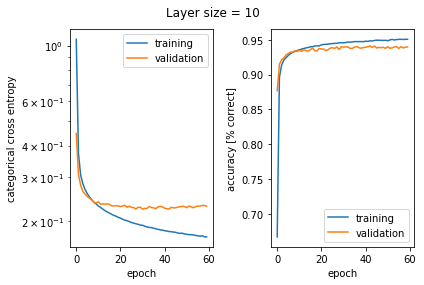

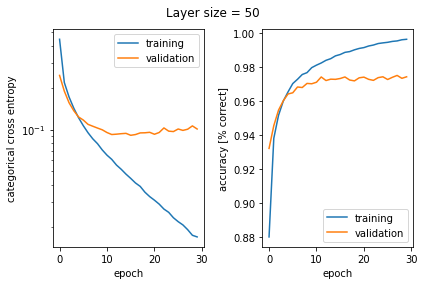

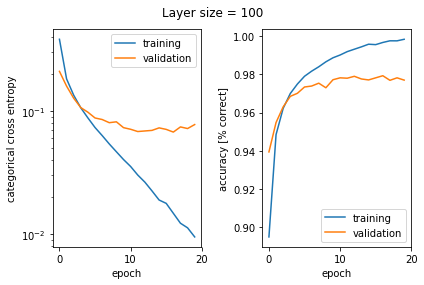

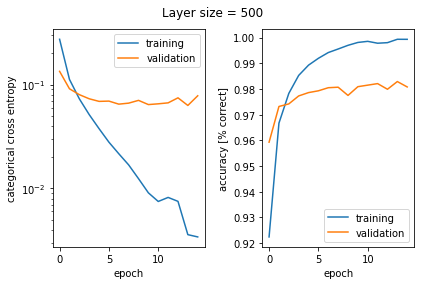

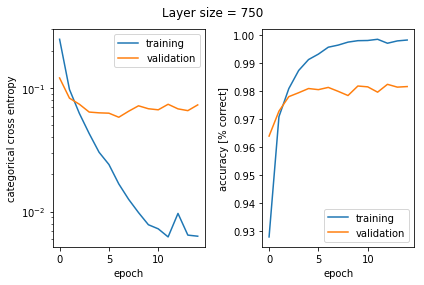

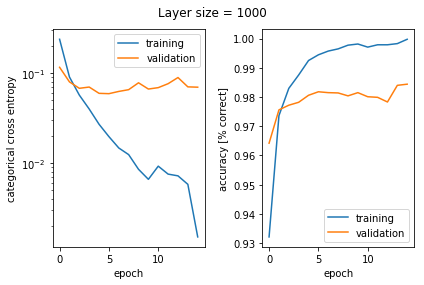

In [10]:
for i, layer_size in enumerate(layer_sizes):
    plot_history(MNIST_Adam_histories[i], "Layer size = " + str(layer_size))

#### Question 4.2

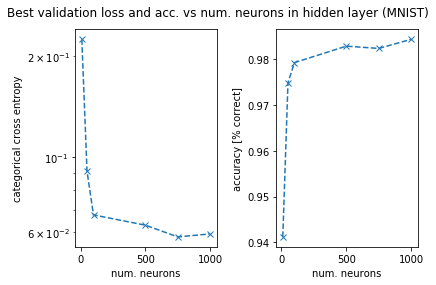

In [11]:
best_val_losses = []
best_val_acc = []
for i, layer_size in enumerate(layer_sizes):
    best_val_losses.append(np.min(MNIST_Adam_histories[i].history['val_loss']))
    best_val_acc.append(np.max(MNIST_Adam_histories[i].history['val_acc']))
    

fig, ax1, ax2 = prepare_standardplot("Best validation loss and acc. vs num. neurons in hidden layer (MNIST)", "num. neurons")
ax1.plot(layer_sizes, best_val_losses, '--x')
ax2.plot(layer_sizes, best_val_acc, '--x')
finalize_standardplot(fig, ax1, ax2)

**Answer to question 2:**
According to the general approximation theorem, a monotonously decreasing cross entropy and a monotonously increasing accuracy should be observed. Fluctuations are observed wrt this behaviour since the easiness of MNIST dataset makes the network with 500 neurons reaching an already very high accuracy. 

#### Question 4.3

In [12]:
epochs = [60, 40, 30, 30, 30, 30]

MNIST_Adam_histories = []

for i, layer_size in enumerate(layer_sizes):
    print("Hidden layer size :", layer_size)
    model_1hidden_layer = Sequential([
        Dense(layer_size, input_shape=(ninputs,)), Activation('relu'),
        Dense(noutputs),
        Activation('softmax'),
    ])
    
    model_1hidden_layer.compile(loss='categorical_crossentropy',
          optimizer=Adam(), 
          metrics=['accuracy'])
    
    MNIST_Adam_histories.append(model_1hidden_layer.fit(x_fashion_train, y_fashion_train,
        epochs=epochs[i],
        batch_size=batch_size,
        validation_data = (x_fashion_test, y_fashion_test),
        shuffle=True))

Hidden layer size : 10
Train on 60000 samples, validate on 10000 samples
Epoch 1/60
60000/60000 [==============================] - 1s 15us/step - loss: 0.7715 - acc: 0.7368 - val_loss: 0.5582 - val_acc: 0.8041
Epoch 2/60
60000/60000 [==============================] - 1s 10us/step - loss: 0.5052 - acc: 0.8251 - val_loss: 0.5039 - val_acc: 0.8225
Epoch 3/60
60000/60000 [==============================] - 1s 11us/step - loss: 0.4651 - acc: 0.8387 - val_loss: 0.4789 - val_acc: 0.8293
Epoch 4/60
60000/60000 [==============================] - 1s 11us/step - loss: 0.4421 - acc: 0.8454 - val_loss: 0.4687 - val_acc: 0.8325
Epoch 5/60
60000/60000 [==============================] - 1s 13us/step - loss: 0.4244 - acc: 0.8528 - val_loss: 0.4501 - val_acc: 0.8395
Epoch 6/60
60000/60000 [==============================] - 1s 11us/step - loss: 0.4155 - acc: 0.8554 - val_loss: 0.4448 - val_acc: 0.8421
Epoch 7/60
60000/60000 [==============================] - 1s 11us/step - loss: 0.4061 - acc: 0.8588 - val

Epoch 60/60
60000/60000 [==============================] - 1s 9us/step - loss: 0.3294 - acc: 0.8839 - val_loss: 0.4229 - val_acc: 0.8542
Hidden layer size : 50
Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 1s 16us/step - loss: 0.6066 - acc: 0.7949 - val_loss: 0.4878 - val_acc: 0.8279
Epoch 2/40
60000/60000 [==============================] - 1s 12us/step - loss: 0.4362 - acc: 0.8490 - val_loss: 0.4366 - val_acc: 0.8466
Epoch 3/40
60000/60000 [==============================] - 1s 12us/step - loss: 0.3953 - acc: 0.8621 - val_loss: 0.4288 - val_acc: 0.8495
Epoch 4/40
60000/60000 [==============================] - 1s 12us/step - loss: 0.3715 - acc: 0.8695 - val_loss: 0.4042 - val_acc: 0.8602
Epoch 5/40
60000/60000 [==============================] - 1s 12us/step - loss: 0.3549 - acc: 0.8742 - val_loss: 0.3945 - val_acc: 0.8597
Epoch 6/40
60000/60000 [==============================] - 1s 12us/step - loss: 0.3412 - acc: 0.8796 - val

60000/60000 [==============================] - 6s 100us/step - loss: 0.1781 - acc: 0.9342 - val_loss: 0.3201 - val_acc: 0.8910
Epoch 17/30
60000/60000 [==============================] - 6s 97us/step - loss: 0.1701 - acc: 0.9366 - val_loss: 0.3457 - val_acc: 0.8792
Epoch 18/30
60000/60000 [==============================] - 6s 97us/step - loss: 0.1646 - acc: 0.9390 - val_loss: 0.3158 - val_acc: 0.8934
Epoch 19/30
60000/60000 [==============================] - 6s 97us/step - loss: 0.1603 - acc: 0.9397 - val_loss: 0.3223 - val_acc: 0.8949
Epoch 20/30
60000/60000 [==============================] - 6s 99us/step - loss: 0.1550 - acc: 0.9425 - val_loss: 0.3320 - val_acc: 0.8955
Epoch 21/30
60000/60000 [==============================] - 6s 98us/step - loss: 0.1499 - acc: 0.9443 - val_loss: 0.3450 - val_acc: 0.8899
Epoch 22/30
60000/60000 [==============================] - 6s 99us/step - loss: 0.1437 - acc: 0.9465 - val_loss: 0.3415 - val_acc: 0.8889
Epoch 23/30
60000/60000 [====================

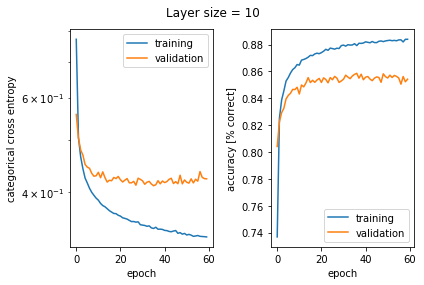

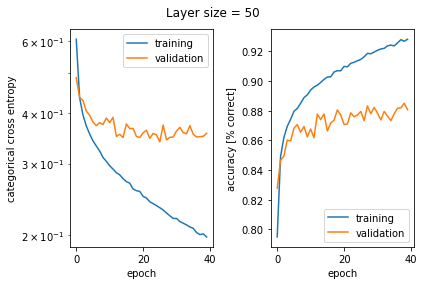

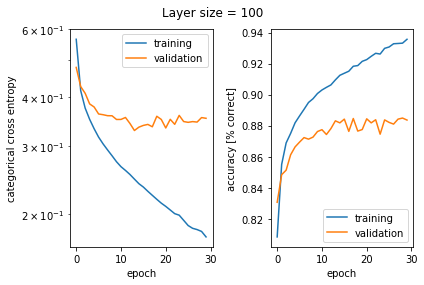

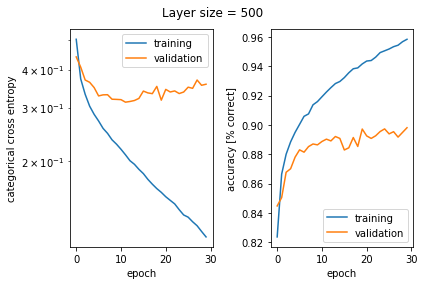

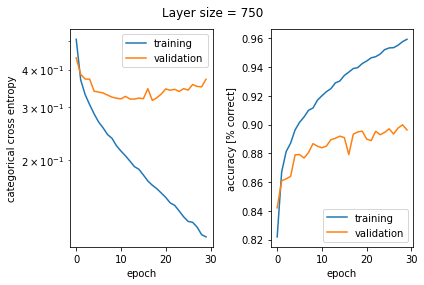

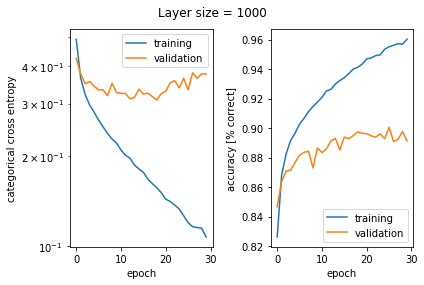

In [13]:
for i, layer_size in enumerate(layer_sizes):
    plot_history(MNIST_Adam_histories[i], "Layer size = " + str(layer_size))

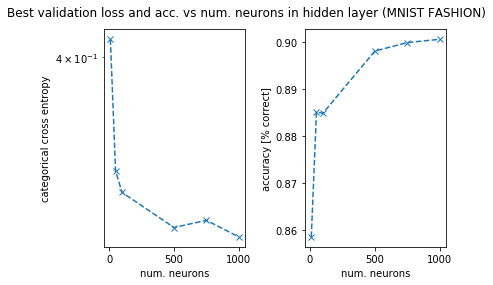

In [14]:
best_val_losses = []
best_val_acc = []
for i, layer_size in enumerate(layer_sizes):
    best_val_losses.append(np.min(MNIST_Adam_histories[i].history['val_loss']))
    best_val_acc.append(np.max(MNIST_Adam_histories[i].history['val_acc']))
    

fig, ax1, ax2 = prepare_standardplot("Best validation loss and acc. vs num. neurons in hidden layer (MNIST FASHION)", "num. neurons")
ax1.plot(layer_sizes, best_val_losses, '--x')
ax2.plot(layer_sizes, best_val_acc, '--x')
finalize_standardplot(fig, ax1, ax2)

**Answer to question 2:** The categorical cross entropy of the network with 750 neurons spikes against the expected behaviour. A cause can be the choice of a specific seed instead of averaging over several of them.

## Exercise 5: Going deeper: tricks and regularization (8 points)

### Description

Adding hidden layers to a deep network does not necessarily lead to a straight-forward improvement of performance. Overfitting can be counteracted with regularization and dropout. Batch normalization is supposed to mainly speed up convergence. Since the MNIST dataset is almost perfectly solved already by a one-hidden-layer network we use the Fashion-MNIST dataset in this exercise.

1. Add one or two hidden layers with 50 hidden neurons (each) and train the network for a sufficiently long time (at least 100 epochs). Since deep models are very expressive you will most probably encounter overfitting. Try to improve the best validation scores of the model (even if it is only a minor improvement) by experimenting with batch_normalization layers, dropout layers and l1- and l2-regularization on weights (kernels) and biases. (4 pts)
2. After you have found good settings, plot the learning curves for both models, naive (=no tricks/regularization) and tuned (=tricks + regularized), preferably together in a comparison plot. Discuss your results; refer to the model performance with only 1 hidden layer. (2 sentences max.) (2pts)
3. Fit your best performing (probably regularized deep) model also to MNIST for having a reference for the next exercise. Plot the resulting learning curves. (2 pts)

### Solution

#### Question 5.1
Deep model no tricks

In [33]:
model_deep = Sequential([
    Dense(750, input_shape=(ninputs,)), Activation('relu'),
    Dense(50), Activation('relu'),
    Dense(50), Activation('relu'),
    Dense(noutputs),
    Activation('softmax'),
])

model_deep.compile(loss='categorical_crossentropy',
      optimizer=Adam(), 
      metrics=['accuracy'])

epochs = 100
batch_size = 128

MNIST_FASHION_notricks_hist = model_deep.fit(x_fashion_train, y_fashion_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data = (x_fashion_test, y_fashion_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 3s 56us/step - loss: 0.5274 - acc: 0.8135 - val_loss: 0.4113 - val_acc: 0.8534
Epoch 2/100
60000/60000 [==============================] - 2s 37us/step - loss: 0.3767 - acc: 0.8628 - val_loss: 0.4450 - val_acc: 0.8337
Epoch 3/100
60000/60000 [==============================] - 2s 38us/step - loss: 0.3323 - acc: 0.8778 - val_loss: 0.3578 - val_acc: 0.8684
Epoch 4/100
60000/60000 [==============================] - 2s 37us/step - loss: 0.3080 - acc: 0.8864 - val_loss: 0.3400 - val_acc: 0.8763
Epoch 5/100
60000/60000 [==============================] - 2s 40us/step - loss: 0.2893 - acc: 0.8925 - val_loss: 0.3451 - val_acc: 0.8744
Epoch 6/100
60000/60000 [==============================] - 2s 38us/step - loss: 0.2719 - acc: 0.8992 - val_loss: 0.3499 - val_acc: 0.8732
Epoch 7/100
60000/60000 [==============================] - 2s 35us/step - loss: 0.2617 - acc: 0.9010 - val_loss: 0.3378 - 

Deep model with tricks

In [24]:
from keras.layers.normalization import BatchNormalization
from keras import regularizers

In [66]:
#kernel_regularizer=regularizers.l1(1e-3)
model_deep_tricks = Sequential([
    Dense(750, input_shape=(ninputs,), activation='relu'), 
    Dropout(0.4),
    Dense(50, activation='relu', kernel_regularizer=regularizers.l2(1e-5)), BatchNormalization(), 
    Dense(50, activation='relu', kernel_regularizer=regularizers.l2(1e-5)), BatchNormalization(),
    Dense(noutputs),
    Activation('softmax'),
])

model_deep_tricks.compile(loss='categorical_crossentropy',
      optimizer=Adam(), 
      metrics=['accuracy'])

MNIST_FASHION_tuned_hist = model_deep_tricks.fit(x_fashion_train, y_fashion_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data = (x_fashion_test, y_fashion_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 7s 114us/step - loss: 0.5674 - acc: 0.8024 - val_loss: 0.4556 - val_acc: 0.8351
Epoch 2/100
60000/60000 [==============================] - 3s 56us/step - loss: 0.4216 - acc: 0.8480 - val_loss: 0.3954 - val_acc: 0.8566
Epoch 3/100
60000/60000 [==============================] - 3s 56us/step - loss: 0.3856 - acc: 0.8583 - val_loss: 0.3674 - val_acc: 0.8665
Epoch 4/100
60000/60000 [==============================] - 3s 56us/step - loss: 0.3653 - acc: 0.8648 - val_loss: 0.3801 - val_acc: 0.8575
Epoch 5/100
60000/60000 [==============================] - 3s 56us/step - loss: 0.3466 - acc: 0.8723 - val_loss: 0.3576 - val_acc: 0.8684
Epoch 6/100
60000/60000 [==============================] - 3s 56us/step - loss: 0.3345 - acc: 0.8763 - val_loss: 0.3380 - val_acc: 0.8771
Epoch 7/100
60000/60000 [==============================] - 3s 57us/step - loss: 0.3252 - acc: 0.8789 - val_loss: 0.3407 -

#### Question 5.2

**Answer to question 2:** The multilayer network without any regularization trick does not improve the cross entropy reached by the one layer with 750 neurons and it clearly overfits since the orange curve in the cross entropy begins to increase soon and drastically. Overfitting is prevented when regularisation is considered and the model performs better than the single-layer one.

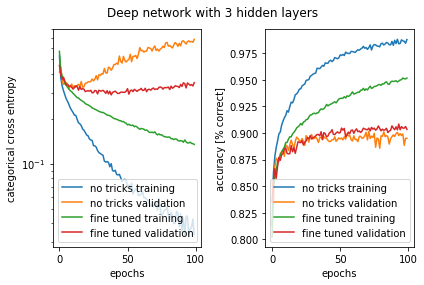

In [67]:
comparison_plot(MNIST_FASHION_notricks_hist, MNIST_FASHION_tuned_hist, "no tricks", "fine tuned", "Deep network with 3 hidden layers")
print()

#### Question 5.3

In [77]:
epochs=15
MNIST_tuned_hist = model_deep_tricks.fit(x_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data = (x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 4s 65us/step - loss: 0.0132 - acc: 0.9977 - val_loss: 0.0800 - val_acc: 0.9838
Epoch 2/15
60000/60000 [==============================] - 4s 63us/step - loss: 0.0128 - acc: 0.9977 - val_loss: 0.0803 - val_acc: 0.9847
Epoch 3/15
60000/60000 [==============================] - 3s 57us/step - loss: 0.0138 - acc: 0.9971 - val_loss: 0.0732 - val_acc: 0.9862
Epoch 4/15
60000/60000 [==============================] - 4s 59us/step - loss: 0.0126 - acc: 0.9977 - val_loss: 0.0795 - val_acc: 0.9856
Epoch 5/15
60000/60000 [==============================] - 3s 58us/step - loss: 0.0125 - acc: 0.9978 - val_loss: 0.0779 - val_acc: 0.9858
Epoch 6/15
60000/60000 [==============================] - 3s 57us/step - loss: 0.0129 - acc: 0.9977 - val_loss: 0.0742 - val_acc: 0.9860
Epoch 7/15
60000/60000 [==============================] - 3s 57us/step - loss: 0.0124 - acc: 0.9979 - val_loss: 0.0734 - val_acc

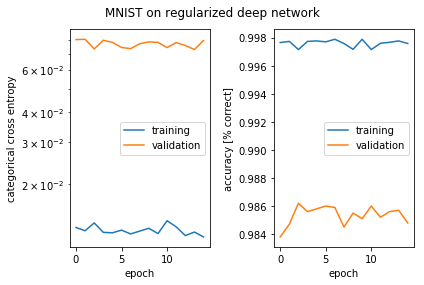

In [78]:
plot_history(MNIST_tuned_hist, "MNIST on regularized deep network")
print()

## Exercise 6: Convolutional neural networks (CNNs) (10 points)

### Description

Convolutional neural networks have an inductive bias that is well adapted to image classification.

1. Design a convolutional neural network, play with different architectures and parameters. Hint: You may get valuable inspiration from the keras [examples](https://github.com/keras-team/keras/tree/master/examples). (4 pts)
2. Plot the learning curves of the convolutional neural network for MNIST and Fashion-MNIST. (4 pts)
3. How does the CNN performance compare to the so far best performing (deep) neural network model for the two data sets? (2 sentences max.) (2 pts)

### Solution

#### Question 6.1

In [9]:
"""
Reshape the data sets to be compatible with CNN
"""
size_img = 28
x_train_cnn = x_train.reshape(x_train.shape[0], size_img, size_img, 1)
x_test_cnn = x_test.reshape(x_test.shape[0], size_img, size_img, 1)


x_fashion_train_cnn = x_fashion_train.reshape(x_train.shape[0], size_img, size_img, 1)
x_fashion_test_cnn = x_fashion_test.reshape(x_test.shape[0], size_img, size_img, 1)

input_shape = (size_img, size_img, 1)

In [10]:
model_cnn = Sequential([
    Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='relu', input_shape=input_shape),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),
    Conv2D(64, kernel_size=(3,3), activation='relu'),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(noutputs, activation='softmax')
])

model_cnn.compile(loss='categorical_crossentropy',
      optimizer=Adam(), 
      metrics=['accuracy'])


In [12]:
epochs = 15
MNIST_FASHION_cnn_hist = model_cnn.fit(x_fashion_train_cnn, y_fashion_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data = (x_fashion_test_cnn, y_fashion_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 4s 59us/step - loss: 0.2636 - acc: 0.9040 - val_loss: 0.2659 - val_acc: 0.9043
Epoch 2/15
60000/60000 [==============================] - 3s 58us/step - loss: 0.2320 - acc: 0.9153 - val_loss: 0.2582 - val_acc: 0.9058
Epoch 3/15
60000/60000 [==============================] - 3s 58us/step - loss: 0.2081 - acc: 0.9242 - val_loss: 0.2391 - val_acc: 0.9152
Epoch 4/15
60000/60000 [==============================] - 4s 58us/step - loss: 0.1896 - acc: 0.9295 - val_loss: 0.2497 - val_acc: 0.9094
Epoch 5/15
60000/60000 [==============================] - 4s 58us/step - loss: 0.1728 - acc: 0.9364 - val_loss: 0.2251 - val_acc: 0.9182
Epoch 6/15
60000/60000 [==============================] - 3s 58us/step - loss: 0.1581 - acc: 0.9418 - val_loss: 0.2359 - val_acc: 0.9197
Epoch 7/15
60000/60000 [==============================] - 3s 58us/step - loss: 0.1401 - acc: 0.9488 - val_loss: 0.2386 - val_acc

In [13]:
epochs = 15
MNIST_cnn_hist = model_cnn.fit(x_train_cnn, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data = (x_test_cnn, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/15
60000/60000 [==============================] - 4s 59us/step - loss: 0.2093 - acc: 0.9513 - val_loss: 0.0467 - val_acc: 0.9854
Epoch 2/15
60000/60000 [==============================] - 3s 58us/step - loss: 0.0426 - acc: 0.9864 - val_loss: 0.0368 - val_acc: 0.9880
Epoch 3/15
60000/60000 [==============================] - 4s 58us/step - loss: 0.0285 - acc: 0.9914 - val_loss: 0.0395 - val_acc: 0.9879
Epoch 4/15
60000/60000 [==============================] - 3s 58us/step - loss: 0.0196 - acc: 0.9941 - val_loss: 0.0321 - val_acc: 0.9897
Epoch 5/15
60000/60000 [==============================] - 3s 58us/step - loss: 0.0130 - acc: 0.9959 - val_loss: 0.0372 - val_acc: 0.9892
Epoch 6/15
60000/60000 [==============================] - 3s 58us/step - loss: 0.0101 - acc: 0.9968 - val_loss: 0.0362 - val_acc: 0.9905
Epoch 7/15
60000/60000 [==============================] - 4s 58us/step - loss: 0.0082 - acc: 0.9973 - val_loss: 0.0368 - val_acc

#### Question 6.2

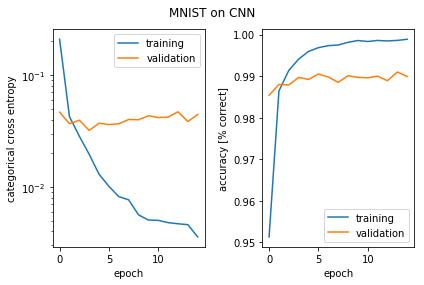

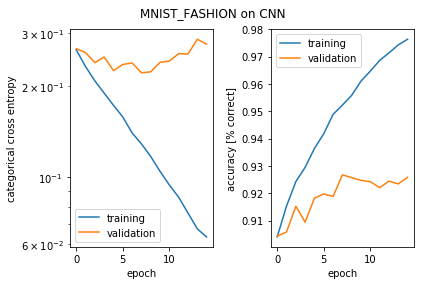

In [14]:
plot_history(MNIST_cnn_hist, "MNIST on CNN")
plot_history(MNIST_FASHION_cnn_hist, "MNIST_FASHION on CNN")
print()

#### Question 6.3

Answer to question 3:

* The CNN performes better than the best current deep network in both the data sets(in MNIST_FASHION, 90% accuracy for deep network vs 93% accuracy for CNN, while in MNIST, 98,6% for deep network and 99,1% for CNN). This is explained because CNN has the correct inductive bias to detect features in images.

## Exercise 7: Sigmoidal activation function and batch-normalization (6 points)

### Description:

In the original publication of batch normalization [Ioffe and Szegedy, 2014](https://arxiv.org/pdf/1502.03167.pdf), the authors mention a particularly beneficial effect of their method on networks with sigmoidal activation functions. This is because such networks usually suffer from saturating activations/vanishing gradients. Here we want to reproduce this behaviour (Chose either MNIST or Fashion-MNIST for this exercise).

1. Implement the same convolutional network as in the previous exercise, but using the sigmoid activation function instead of the standard choice ReLU. Train the network for a reasonable amount of time. What do you observe? (1 sentence max.) (3 pts)
2. Add batch-normalization layers to all convolutional and fully-connected layers (i.e. before each layer with learnable parameters). How does the performance change? Can the network reach the ReLU-CNN performance of the previous exercise? (1 sentence max.) (3 pts)
3. **BONUS (optional, not graded**): Investigate our initial guess that saturating activity/vanishing gradients might be the cause of this behaviour. For that, create histograms of the hidden activitions for different hidden layers for the sigmoid-CNN and the sigmoid-CNN with batch-normalization (counting over both, samples and neurons per layer). You may only chose layers with learnable parameters. What do you observe?
Hint: You can use the [keract](https://github.com/philipperemy/keract) package to access neural activation values for all layers of your network model.



### Solution:

#### Question 7.1

In [16]:
model_cnn_sigmoidal = Sequential([
    Conv2D(32, kernel_size=(3,3), strides = (1,1), activation='sigmoid', input_shape=input_shape),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),
    Conv2D(64, kernel_size=(3,3), activation='sigmoid'),
    Flatten(),
    Dense(100, activation='sigmoid'),
    Dense(noutputs, activation='softmax')
])


In [17]:
epochs = 30

model_cnn_sigmoidal.compile(loss='categorical_crossentropy',
      optimizer=Adam(), 
      metrics=['accuracy'])

MNIST_cnn_sigmoidal_hist = model_cnn_sigmoidal.fit(x_train_cnn, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data = (x_test_cnn, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 32s 541us/step - loss: 2.3116 - acc: 0.1070 - val_loss: 2.3038 - val_acc: 0.1032
Epoch 2/30
60000/60000 [==============================] - 32s 532us/step - loss: 1.5946 - acc: 0.4216 - val_loss: 0.3086 - val_acc: 0.9191
Epoch 3/30
60000/60000 [==============================] - 32s 538us/step - loss: 0.2262 - acc: 0.9360 - val_loss: 0.1330 - val_acc: 0.9616
Epoch 4/30
60000/60000 [==============================] - 34s 574us/step - loss: 0.1257 - acc: 0.9634 - val_loss: 0.0933 - val_acc: 0.9711
Epoch 5/30
60000/60000 [==============================] - 35s 588us/step - loss: 0.0919 - acc: 0.9733 - val_loss: 0.0793 - val_acc: 0.9758
Epoch 6/30
60000/60000 [==============================] - 36s 606us/step - loss: 0.0719 - acc: 0.9790 - val_loss: 0.0627 - val_acc: 0.9806
Epoch 7/30
60000/60000 [==============================] - 35s 589us/step - loss: 0.0603 - acc: 0.9821 - val_loss: 0.

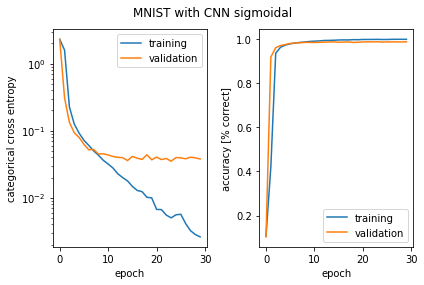

In [18]:
plot_history(MNIST_cnn_sigmoidal_hist, "MNIST with CNN sigmoidal")
print()

Answer to question 1:

* Considering the vanishing gradient problem of sigmoid, the model learns slower than the same model with relu (first epoch for sigm. is about 10% accuracy).

#### Question 7.2

In [25]:
model_cnn_sigmoidal_batchNorm = Sequential([
    BatchNormalization(),
    Conv2D(32, kernel_size=(3,3), strides=(1,1), activation='sigmoid', input_shape=input_shape),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.2),
    BatchNormalization(),
    Conv2D(64, kernel_size=(3,3), activation='sigmoid'),
    Flatten(),
    BatchNormalization(),
    Dense(100, activation='sigmoid'),
    BatchNormalization(),
    Dense(noutputs, activation='softmax')
])

epochs = 30

model_cnn_sigmoidal_batchNorm.compile(loss='categorical_crossentropy',
      optimizer=Adam(), 
      metrics=['accuracy'])

MNIST_tuned_cnn_sigm_hist = model_cnn_sigmoidal_batchNorm.fit(x_train_cnn, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data = (x_test_cnn, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 6s 106us/step - loss: 0.3493 - acc: 0.8949 - val_loss: 0.1462 - val_acc: 0.9578
Epoch 2/30
60000/60000 [==============================] - 5s 88us/step - loss: 0.1452 - acc: 0.9582 - val_loss: 0.0912 - val_acc: 0.9730
Epoch 3/30
60000/60000 [==============================] - 5s 88us/step - loss: 0.0952 - acc: 0.9716 - val_loss: 0.0689 - val_acc: 0.9789
Epoch 4/30
60000/60000 [==============================] - 5s 88us/step - loss: 0.0732 - acc: 0.9779 - val_loss: 0.0536 - val_acc: 0.9815
Epoch 5/30
60000/60000 [==============================] - 5s 88us/step - loss: 0.0594 - acc: 0.9814 - val_loss: 0.0482 - val_acc: 0.9841
Epoch 6/30
60000/60000 [==============================] - 5s 88us/step - loss: 0.0492 - acc: 0.9842 - val_loss: 0.0410 - val_acc: 0.9861
Epoch 7/30
60000/60000 [==============================] - 5s 88us/step - loss: 0.0439 - acc: 0.9857 - val_loss: 0.0419 - val_ac

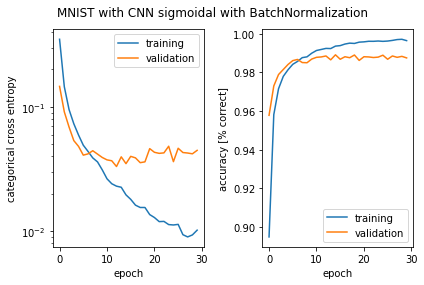

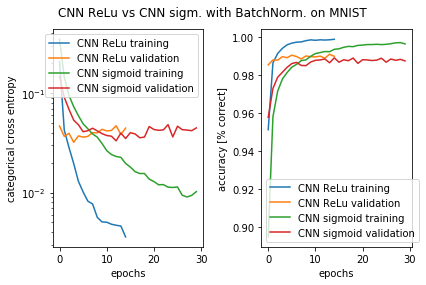

In [30]:
plot_history(MNIST_tuned_cnn_sigm_hist, "MNIST with CNN sigmoidal with BatchNormalization")
comparison_plot(MNIST_cnn_hist, MNIST_tuned_cnn_sigm_hist, "CNN ReLu", "CNN sigmoid", "CNN ReLu vs CNN sigm. with BatchNorm. on MNIST")
print()

Answer to question 2:
* BatchNormalization avoids vanishing gradient and the accuracy after the first epoch is much better.